## Keras denoising autoencoder

https://github.com/keras-team/keras/blob/master/examples/mnist_denoising_autoencoder.py

In [1]:
'''Trains a denoising autoencoder on MNIST dataset.
Denoising is one of the classic applications of autoencoders.
The denoising process removes unwanted noise that corrupted the
true signal.
Noise + Data ---> Denoising Autoencoder ---> Data
Given a training dataset of corrupted data as input and
true signal as output, a denoising autoencoder can recover the
hidden structure to generate clean data.
This example has modular design. The encoder, decoder and autoencoder
are 3 models that share weights. For example, after training the
autoencoder, the encoder can be used to  generate latent vectors
of input data for low-dim visualization like PCA or TSNE.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [3]:
# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Build the Autoencoder Model
# First build the Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

# Build the Decoder Model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decode

In [10]:
print(x_train_noisy.shape, x_train.shape,
      x_test_noisy.shape, x_test.shape)

(60000, 28, 28, 1) (60000, 28, 28, 1) (10000, 28, 28, 1) (10000, 28, 28, 1)


In [4]:
# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)


Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 42s 696us/step - loss: 0.0604 - val_loss: 0.0341
Epoch 2/30
60000/60000 [==============================] - 9s 142us/step - loss: 0.0272 - val_loss: 0.0227
Epoch 3/30
60000/60000 [==============================] - 9s 142us/step - loss: 0.0215 - val_loss: 0.0200
Epoch 4/30
60000/60000 [==============================] - 9s 142us/step - loss: 0.0196 - val_loss: 0.0187
Epoch 5/30
60000/60000 [==============================] - 9s 142us/step - loss: 0.0185 - val_loss: 0.0180
Epoch 6/30
60000/60000 [==============================] - 8s 141us/step - loss: 0.0178 - val_loss: 0.0176
Epoch 7/30
60000/60000 [==============================] - 8s 141us/step - loss: 0.0173 - val_loss: 0.0173
Epoch 8/30
60000/60000 [==============================] - 8s 141us/step - loss: 0.0170 - val_loss: 0.0169
Epoch 9/30
60000/60000 [==============================] - 8s 140us/step - loss: 0.0166 - val_loss: 0.

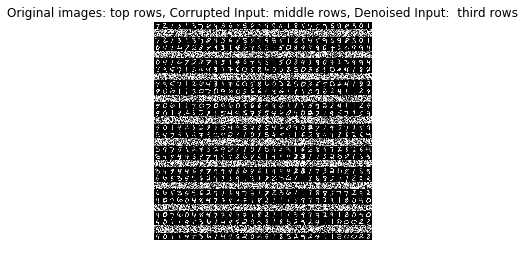

In [5]:
# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)

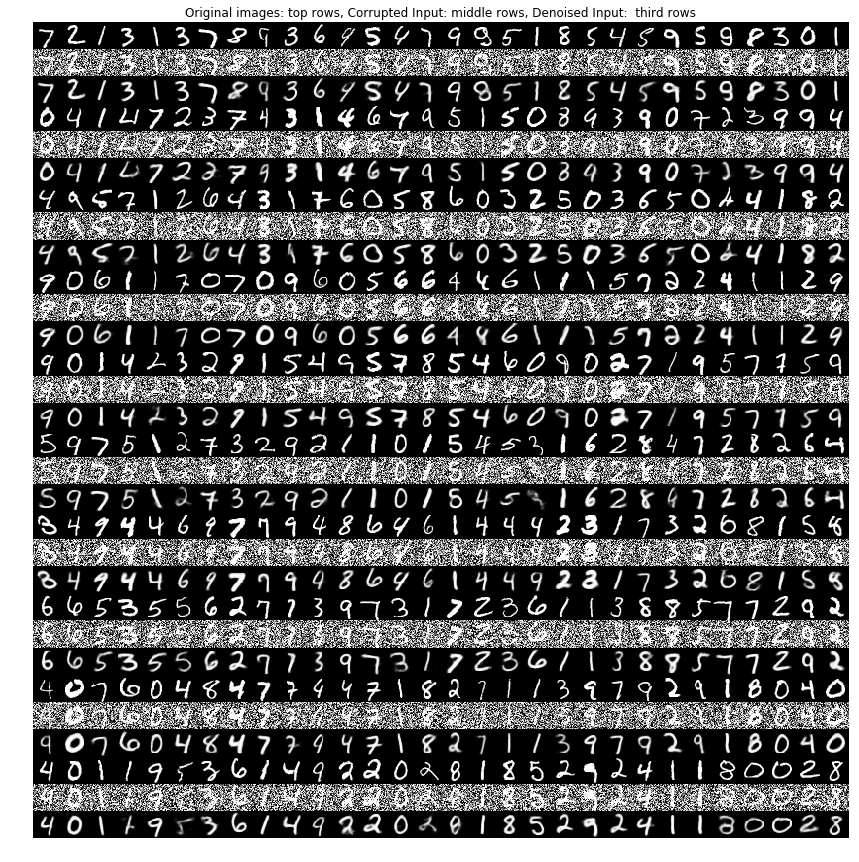

In [7]:
plt.rcParams['figure.figsize'] = (15, 15)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()